# Import libraries

In [1]:
import sys

sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))

import os

os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sem_covid.services.data_registry import Dataset
from sem_covid.services.store_registry import StoreRegistry
from sem_covid.entrypoints.notebooks.EDA.eda_wrangling.data_observations import calc_freq_categorical_data

In [2]:
plt.style.use('ggplot')

# Methods

In [3]:
def update_dataframes(list_of_dfs: list, column_values: list, column_name: str) -> list:
    """
    It is possible that some dataframes do not contain all values of a given column.
    Therefore, this function is used for adding a new row which contains the missing column
    and corresponding relative frequency (0 since it missing)

    :return: list with updated dataframes
    """
    updated_dfs = []
    for df in list_of_dfs:
        if len(df) == len(column_values):
            pass
        else:
            for column_val in column_values:
                if column_val not in list(df[column_name]):
                    df = df.append({column_name: column_val, 'Relative freq': 0}, ignore_index=True)
        updated_dfs.append(df)
    return updated_dfs


def adjusted_target_group_refactoring(pwdb_dataframe: pd.DataFrame,
                                      target_group_column_name: str = 'target_groups') -> pd.DataFrame:
    """
    The target group available in the original dataset is very granular. For the purpose of this exercise
    we would benefit from aggregating the target groups into a more generic sets. As a result we will obtain
    target groups on two levels: L1, L2.
    L1: workers, businesses, citizens
    L2: the original set of categories

    :return: the given dataset with an extra column containing the aggregated (L1) values
    """
    new_columns = {'Businesses': BUSINESSES, 'Citizens': CITIZENS, 'Workers': WORKERS}
    refactored_pwdb_df = pwdb_dataframe[target_group_column_name]
    for column, class_set in new_columns.items():
        pwdb_dataframe[column] = refactored_pwdb_df.apply(lambda x: any(item in class_set for item in x))
        pwdb_dataframe[column].replace({True: column + "_True", False: column + "_False"}, inplace=True)
    return pwdb_dataframe

# Fetch the data

In [4]:
pwdb = Dataset.PWDB.fetch()
eurlex_enriched = Dataset.EU_CELLAR_ENRICHED.fetch()
eu_timeline_enriched = Dataset.EU_ACTION_TIMELINE_ENRICHED.fetch()
ireland_timeline_enriched = Dataset.IRELAND_ACTION_TIMELINE_ENRICHED.fetch()

100% (1368 of 1368) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (2653 of 2653) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (171 of 171) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (410 of 410) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


# Main

Category column

In [5]:
pwdb_rel_obs_categ = calc_freq_categorical_data(pwdb['category'], 'category', True)
eurlex_rel_obs_categ = calc_freq_categorical_data(eurlex_enriched['category'], 'category', True)
eu_timeline_rel_obs_categ = calc_freq_categorical_data(eu_timeline_enriched['category'], 'category', True)
ireland_timeline_rel_obs_categ = calc_freq_categorical_data(ireland_timeline_enriched['category'], 'category', True)

Push the data to ES

In [6]:
# --- pdwb
t_pdwb = pwdb_rel_obs_categ.drop(columns="category")
t_pdwb.rename(columns={t_pdwb.columns[0]: "PWDB"}, inplace=True)
t_pdwb = t_pdwb.T
t_pdwb.rename(columns=pwdb_rel_obs_categ["category"], inplace=True)

# ----- eurlex
t_eurlex_rel_obs_categ = eurlex_rel_obs_categ.drop(columns="category")
t_eurlex_rel_obs_categ.rename(columns={t_eurlex_rel_obs_categ.columns[0]: "EU Cellar"}, inplace=True)
t_eurlex_rel_obs_categ = t_eurlex_rel_obs_categ.T
t_eurlex_rel_obs_categ.rename(columns=eurlex_rel_obs_categ["category"], inplace=True)

# ----- EU Timeline
t_eu_timeline_rel_obs_categ = eu_timeline_rel_obs_categ.drop(columns="category")
t_eu_timeline_rel_obs_categ.rename(columns={t_eu_timeline_rel_obs_categ.columns[0]: "EU Timeline"}, inplace=True)
t_eu_timeline_rel_obs_categ = t_eu_timeline_rel_obs_categ.T
t_eu_timeline_rel_obs_categ.rename(columns=eu_timeline_rel_obs_categ["category"], inplace=True)

# ----- Ireland Timeline
t_ireland_timeline_rel_obs_categ = ireland_timeline_rel_obs_categ.drop(columns="category")
t_ireland_timeline_rel_obs_categ.rename(columns={t_ireland_timeline_rel_obs_categ.columns[0]: "Ireland Timeline"},
                                        inplace=True)
t_ireland_timeline_rel_obs_categ = t_ireland_timeline_rel_obs_categ.T
t_ireland_timeline_rel_obs_categ.rename(columns=ireland_timeline_rel_obs_categ["category"], inplace=True)

# --- concat. and sent to ES
fs = StoreRegistry().es_feature_store()
t = pd.concat([t_pdwb, t_eurlex_rel_obs_categ, t_eu_timeline_rel_obs_categ, t_ireland_timeline_rel_obs_categ], axis=0)
t.fillna(0, inplace=True)
fs.put_features("tmp_fs_relative_category", t.T)

N/A% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

In [7]:
dfs_with_rel_freqs = [pwdb_rel_obs_categ, eurlex_rel_obs_categ, eu_timeline_rel_obs_categ,
                      ireland_timeline_rel_obs_categ]

In [8]:
categories = list(pwdb_rel_obs_categ['category'])
categories.sort()

In [9]:
dfs_with_rel_freqs_updated = update_dataframes(dfs_with_rel_freqs, categories, 'category')

In [10]:
for dataframe in dfs_with_rel_freqs_updated:
    dataframe.sort_values(by=['category'], inplace=True)

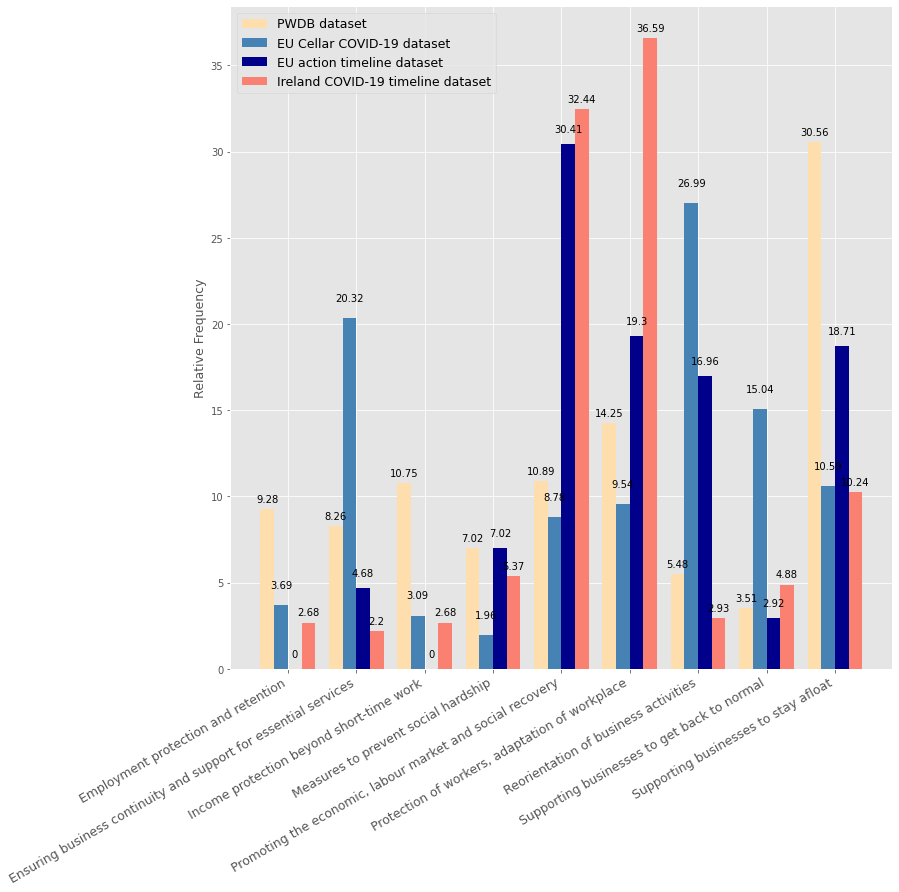

In [11]:
first_bars = list(dfs_with_rel_freqs_updated[0]['Relative freq'])
second_bars = list(dfs_with_rel_freqs_updated[1]['Relative freq'])
third_bars = list(dfs_with_rel_freqs_updated[2]['Relative freq'])
fourth_bars = list(dfs_with_rel_freqs_updated[3]['Relative freq'])

x = np.arange(len(categories))
width = 0.2

fig, ax = plt.subplots(figsize=(12.5, 12.5))
rects1 = ax.bar(x - width * 2, first_bars, width, label='PWDB dataset', color='navajowhite')
rects2 = ax.bar(x - width * 1, second_bars, width, label='EU Cellar COVID-19 dataset', color='steelblue')
rects3 = ax.bar(x, third_bars, width, label='EU action timeline dataset', color='darkblue')
rects4 = ax.bar(x + width * 1, fourth_bars, width, label='Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize': 12.5}, rotation=30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=15)
ax.bar_label(rects3, padding=10)
ax.bar_label(rects4, padding=5)

fig.tight_layout()

plt.show()

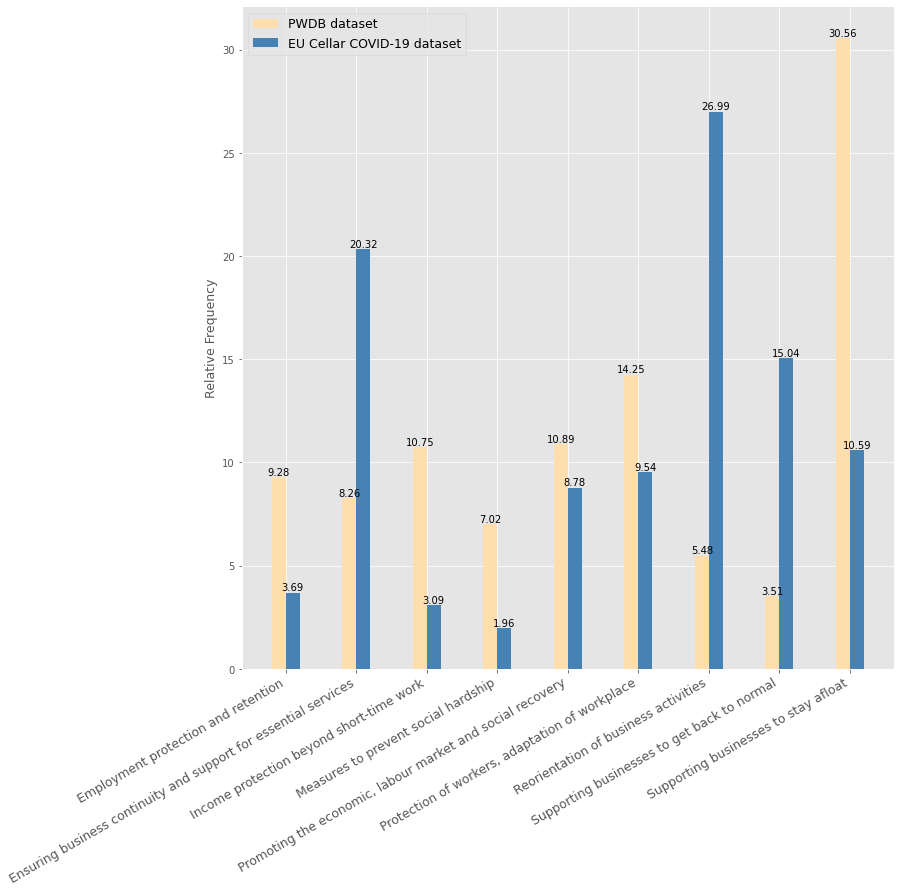

In [12]:
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12.5, 12.5))
rects1 = ax.bar(x - width, first_bars, width, label='PWDB dataset', color='navajowhite')
rects2 = ax.bar(x, second_bars, width, label='EU Cellar COVID-19 dataset', color='steelblue')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize': 12.5}, rotation=30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, )
ax.bar_label(rects2, )

fig.tight_layout()

plt.show()

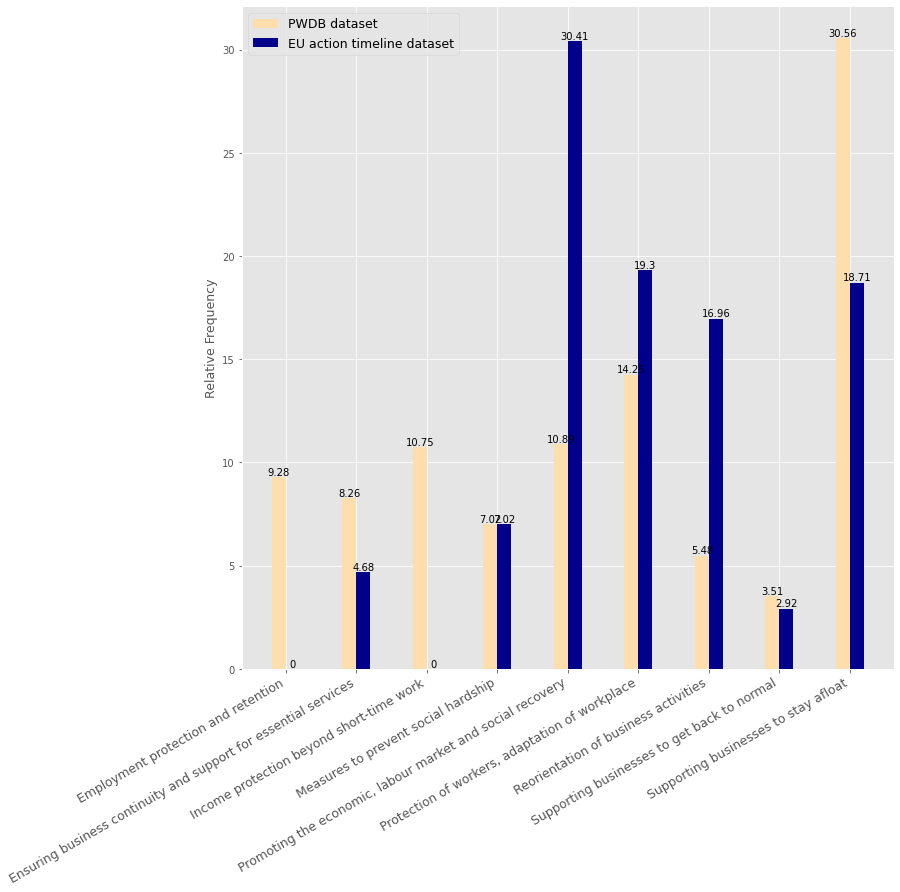

In [13]:
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12.5, 12.5))
rects1 = ax.bar(x - width, first_bars, width, label='PWDB dataset', color='navajowhite')
rects3 = ax.bar(x, third_bars, width, label='EU action timeline dataset', color='darkblue')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize': 12.5}, rotation=30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, )
ax.bar_label(rects3, )

fig.tight_layout()

plt.show()

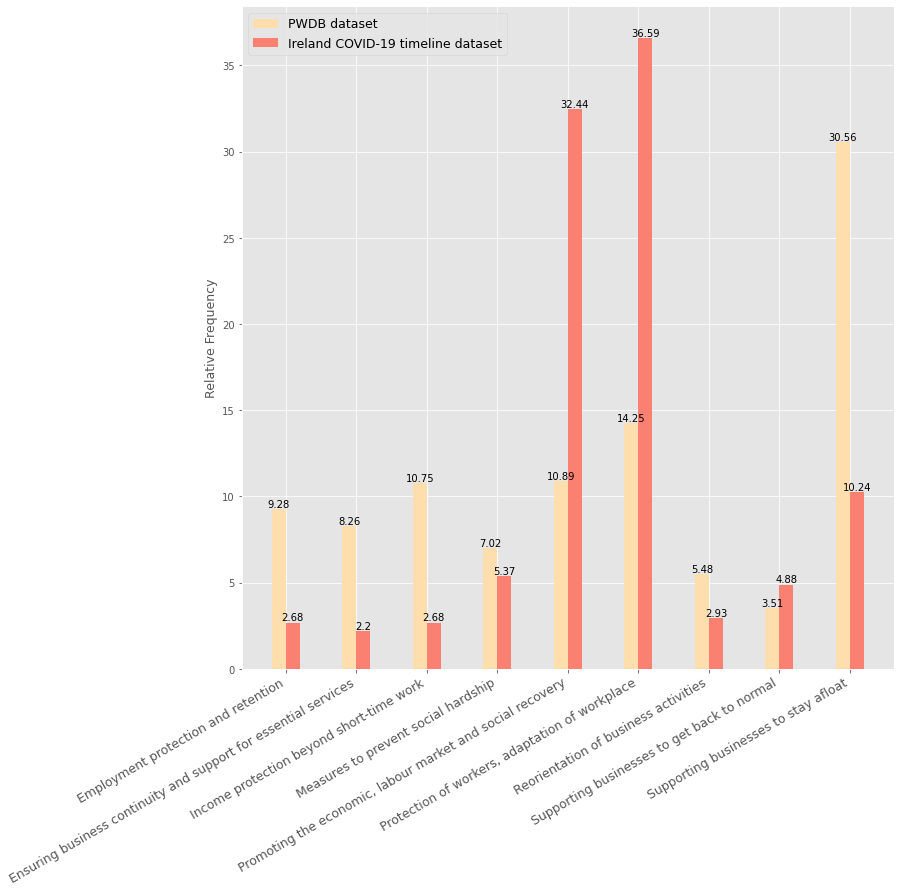

In [14]:
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12.5, 12.5))
rects1 = ax.bar(x - width, first_bars, width, label='PWDB dataset', color='navajowhite')
rects4 = ax.bar(x, fourth_bars, width, label='Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize': 12.5}, rotation=30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, )
ax.bar_label(rects4)

fig.tight_layout()

plt.show()

Type of measure column

In [ ]:
pwdb_rel_obs_type = calc_freq_categorical_data(pwdb['type_of_measure'], 'type_of_measure', True)
eurlex_rel_obs_type = calc_freq_categorical_data(eurlex_enriched['type_of_measure'], 'type_of_measure', True)
eu_timeline_rel_obs_type = calc_freq_categorical_data(eu_timeline_enriched['type_of_measure'], 'type_of_measure', True)
ireland_timeline_rel_obs_type = calc_freq_categorical_data(ireland_timeline_enriched['type_of_measure'],
                                                           'type_of_measure', True)

In [ ]:
dfs_with_rel_freqs = [pwdb_rel_obs_type, eurlex_rel_obs_type, eu_timeline_rel_obs_type, ireland_timeline_rel_obs_type]

In [ ]:
types = list(pwdb_rel_obs_type['type_of_measure'])
types.sort()

In [ ]:
dfs_with_rel_freqs_updated = update_dataframes(dfs_with_rel_freqs, types, 'type_of_measure')

In [ ]:
for dataframe in dfs_with_rel_freqs_updated:
    dataframe.sort_values(by=['type_of_measure'], inplace=True)

In [ ]:
first_bars = list(dfs_with_rel_freqs_updated[0]['Relative freq'])
second_bars = list(dfs_with_rel_freqs_updated[1]['Relative freq'])
third_bars = list(dfs_with_rel_freqs_updated[2]['Relative freq'])
fourth_bars = list(dfs_with_rel_freqs_updated[3]['Relative freq'])

x = np.arange(len(types))
width = 0.2

fig, ax = plt.subplots(figsize=(12.5, 12.5))
rects1 = ax.bar(x - width * 2, first_bars, width, label='PWDB dataset', color='navajowhite')
rects2 = ax.bar(x - width * 1, second_bars, width, label='EU Cellar COVID-19 dataset', color='steelblue')
rects3 = ax.bar(x, third_bars, width, label='EU action timeline dataset', color='darkblue')
rects4 = ax.bar(x + width * 1, fourth_bars, width, label='Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(types, fontdict={'fontsize': 12.5}, rotation=30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.bar_label(rects3, padding=5)
ax.bar_label(rects4, padding=5)

fig.tight_layout()

plt.show()

L1 column

In [ ]:
BUSINESSES = {'Companies providing essential services', 'Contractors of a company', 'Larger corporations',
              'One person or microenterprises', 'Other businesses', 'SMEs', 'Sector specific set of companies',
              'Solo-self-employed', 'Start-ups'}

CITIZENS = {'Children (minors)', 'Disabled', 'Migrants', 'Older citizens', 'Other groups of citizens', 'Parents',
            'People in care facilities', 'Refugees', 'Single parents', 'The COVID-19 risk group', 'Women',
            'Youth (18-25)'}

WORKERS = {'Cross-border commuters', 'Disabled workers', 'Employees in standard employment', 'Female workers',
           'Migrants in employment', 'Older people in employment (aged 55+)', 'Other groups of workers',
           'Parents in employment', 'Particular professions', 'Platform workers', 'Posted workers',
           'Refugees in employment', 'Seasonal workers', 'Self-employed', 'Single parents in employment',
           'The COVID-19 risk group at the workplace', 'Undeclared workers', 'Unemployed', 'Workers in care facilities',
           'Workers in essential services', 'Workers in non-standard forms of employment',
           'Youth (18-25) in employment'}

In [ ]:
pwdb = adjusted_target_group_refactoring(pwdb)

In [ ]:
pwdb_rel_obs_businesses = calc_freq_categorical_data(pwdb['Businesses'], 'businesses', True)
eurlex_rel_obs_businesses = calc_freq_categorical_data(eurlex_enriched['businesses'], 'businesses', True)
eu_timeline_rel_obs_businesses = calc_freq_categorical_data(eu_timeline_enriched['businesses'], 'businesses', True)
ireland_timeline_rel_obs_businesses = calc_freq_categorical_data(ireland_timeline_enriched['businesses'], 'businesses',
                                                                 True)

In [ ]:
pwdb_rel_obs_citizens = calc_freq_categorical_data(pwdb['Citizens'], 'citizens', True)
eurlex_rel_obs_citizens = calc_freq_categorical_data(eurlex_enriched['citizens'], 'citizens', True)
eu_timeline_rel_obs_citizens = calc_freq_categorical_data(eu_timeline_enriched['citizens'], 'citizens', True)
ireland_timeline_rel_obs_citizens = calc_freq_categorical_data(ireland_timeline_enriched['citizens'], 'citizens', True)

In [ ]:
pwdb_rel_obs_workers = calc_freq_categorical_data(pwdb['Workers'], 'workers', True)
eurlex_rel_obs_workers = calc_freq_categorical_data(eurlex_enriched['workers'], 'workers', True)
eu_timeline_rel_obs_workers = calc_freq_categorical_data(eu_timeline_enriched['workers'], 'workers', True)
ireland_timeline_rel_obs_workers = calc_freq_categorical_data(ireland_timeline_enriched['workers'], 'workers', True)

In [ ]:
first_bars = [pwdb_rel_obs_businesses['Relative freq'][1], pwdb_rel_obs_citizens['Relative freq'][1],
              pwdb_rel_obs_workers['Relative freq'][1]]
second_bars = [eurlex_rel_obs_businesses['Relative freq'][1], eurlex_rel_obs_citizens['Relative freq'][1],
               eurlex_rel_obs_workers['Relative freq'][1]]
third_bars = [eu_timeline_rel_obs_businesses['Relative freq'][0], eu_timeline_rel_obs_citizens['Relative freq'][1],
              eu_timeline_rel_obs_workers['Relative freq'][1]]
fourth_bars = [ireland_timeline_rel_obs_businesses['Relative freq'][1],
               ireland_timeline_rel_obs_citizens['Relative freq'][1],
               ireland_timeline_rel_obs_workers['Relative freq'][1]]

In [ ]:
x = np.arange(3)
width = 0.2

fig, ax = plt.subplots(figsize=(12.5, 12.5))
rects1 = ax.bar(x - width * 2, first_bars, width, label='PWDB dataset', color='navajowhite')
rects2 = ax.bar(x - width * 1, second_bars, width, label='EU Cellar COVID-19 dataset', color='steelblue')
rects3 = ax.bar(x, third_bars, width, label='EU action timeline dataset', color='darkblue')
rects4 = ax.bar(x + width * 1, fourth_bars, width, label='Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(['Businesses', 'Citizens', 'Workers'], fontdict={'fontsize': 12.5}, rotation=30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.bar_label(rects3, padding=5)
ax.bar_label(rects4, padding=5)

fig.tight_layout()

plt.show()

## Funding column


In [59]:
funding_columns = list(set(np.concatenate(pwdb.funding.values)))

In [60]:
funding_columns

['Employers organisation',
 'Employees',
 'European Funds',
 'Social partners jointly',
 'Local funds',
 'National funds',
 'No special funding required',
 'Regional funds',
 'Other',
 'Trade union',
 'Employer',
 'Companies']

In [61]:
eurlex_enriched.funding = eurlex_enriched.funding.str.split('|')
eu_timeline_enriched.funding = eu_timeline_enriched.funding.str.split('|')
ireland_timeline_enriched.funding = ireland_timeline_enriched.funding.str.split('|')

In [79]:
def split_column_in_binary_columns(data: pd.DataFrame, target_column: str, new_columns: list):
    result_df = pd.DataFrame(data)
    result_df[new_columns] = 0
    def update_row(entry_row, column_name:str):
        for column in entry_row[column_name]:
            entry_row[column] = 1
        return entry_row
    result_df= result_df.apply(lambda row: update_row(row,target_column),axis=1)
    return result_df

In [86]:
pwdb = split_column_in_binary_columns(pwdb,'funding',funding_columns)
eurlex_enriched = split_column_in_binary_columns(eurlex_enriched,'funding',funding_columns)
eu_timeline_enriched = split_column_in_binary_columns(eu_timeline_enriched,'funding',funding_columns)
ireland_timeline_enriched = split_column_in_binary_columns(ireland_timeline_enriched,'funding',funding_columns)


In [93]:
first_bars = [100- calc_freq_categorical_data(pwdb[column],column,True)['Relative freq'][0]
                                for column in funding_columns]
second_bars = [100 -calc_freq_categorical_data(eurlex_enriched[column],column,True)['Relative freq'][0]
                                for column in funding_columns]
third_bars = [100 -calc_freq_categorical_data(eu_timeline_enriched[column],column,True)['Relative freq'][0]
                                for column in funding_columns]
fourth_bars = [100 -calc_freq_categorical_data(ireland_timeline_enriched[column],column,True)['Relative freq'][0]
                                for column in funding_columns]

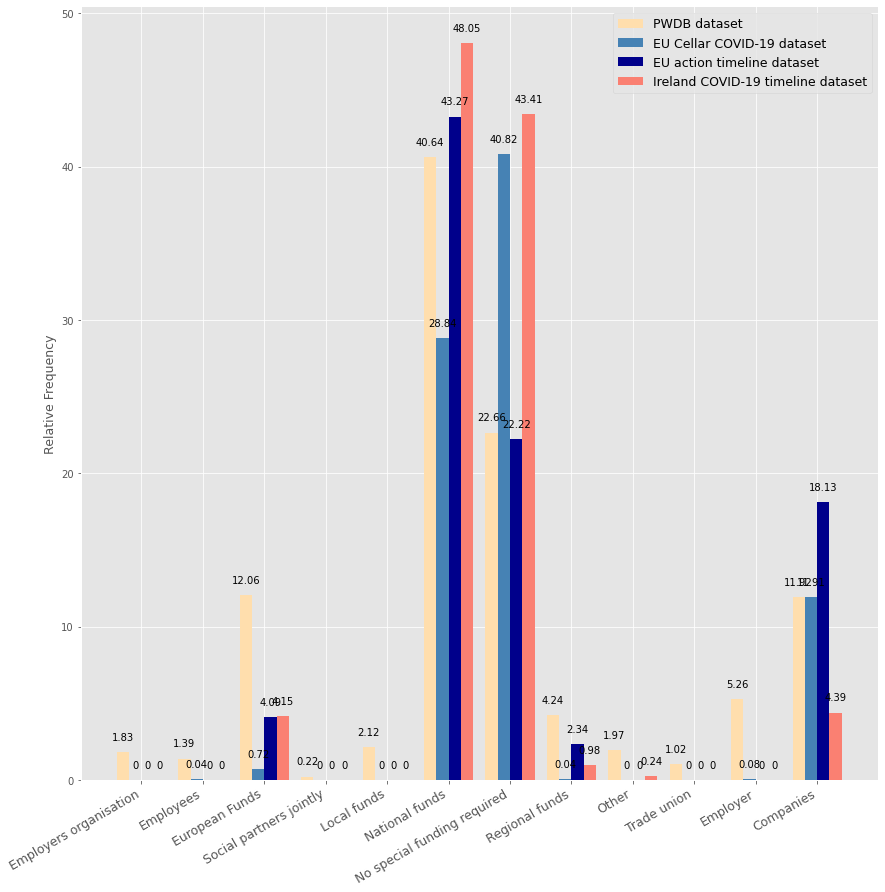

In [105]:
x = np.arange(12)
width = 0.2

fig, ax = plt.subplots(figsize=(12.5, 12.5))
rects1 = ax.bar(x - width * 2, first_bars, width, label='PWDB dataset', color='navajowhite')
rects2 = ax.bar(x - width * 1, second_bars, width, label='EU Cellar COVID-19 dataset', color='steelblue')
rects3 = ax.bar(x, third_bars, width, label='EU action timeline dataset', color='darkblue')
rects4 = ax.bar(x + width * 1, fourth_bars, width, label='Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(funding_columns, fontdict={'fontsize': 12.5}, rotation=30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, padding=10)
ax.bar_label(rects2, padding=10)
ax.bar_label(rects3, padding=10)
ax.bar_label(rects4, padding=10)

fig.tight_layout()
plt.show()